In [381]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [382]:
def shorten_model_name(name):
    name = name.replace("Qwen/Qwen2.5-VL-7B-Instruct", "Qwen7B")
    name = name.replace("OpenGVLab/InternVL3-8B", "Intern8B")
    name = name.replace("llava-hf/llava-v1.6-mistral-7b-hf", "LLaVA7B")
    return name


def fill_correct(df, half_scores = False):
    df = df.copy()
    if half_scores:
        df['is_correct'] = df['score'].apply(
            lambda x: 1 if str(x).strip().lower() == 'right'
            else 0.5 if str(x).strip().lower() == 'somewhat right' 
            else 0
            )
    else:
        df['is_correct'] = df['score'].apply(
            lambda x: 1 if str(x).strip().lower() == 'right' 
            else 0
        )
    return df

def clean_df(df, subset_cols,):
    df = df.copy()
    df = df.dropna(subset=subset_cols).drop_duplicates(subset=subset_cols, keep='last')
    return df

def prepare_df(df, half_scores = False):
    df = df.copy()
    df = df[df["judge_model_name"] != "Qwen2.5-VL-7B-Instruct"]
    df = df[df["model_name"] != "Qwen/Qwen2.5-VL-32B-Instruct"]
    df = fill_correct(df, half_scores=half_scores)
    df['model_name'] = df['model_name'].apply(shorten_model_name)
    single_subset_cols = [
            "problem_id",
            "dataset_name",
            "model_name",
            "strategy_name",
            "version"
        ]
    df_singles = df[df["ensemble"] == False]
    df_singles = clean_df(df_singles, subset_cols=single_subset_cols)
    return df_singles

In [383]:
df = pd.read_csv('../results/all_results_concat.csv')
df_singles = prepare_df(df, half_scores=True)
df_singles_no_half_scores = prepare_df(df, half_scores=False)

## Top models

In [ ]:
top_setup = df_singles.copy()

top_setup = top_setup[top_setup["version"].isin([1,2,3])]

group_cols=["strategy_name", "model_name", "version", "dataset_name"]

grouped = top_setup.groupby(group_cols)["is_correct"]
score = grouped.sum()
total = grouped.count()
correctness = score / total * 100

top_setup = pd.DataFrame({
    "total_score": score,
    "all_possible": total,
    "correctness": correctness
}).reset_index()

top_setup= top_setup.sort_values("correctness", ascending=False).reset_index(drop=True)
top_setup.head(10)

### Average across datasets

In [279]:
avg_across_datasets = top_setup[top_setup["version"].isin([1,3])]

group_cols=["strategy_name", "model_name", "version"]

grouped = avg_across_datasets.groupby(group_cols)["correctness"]
score = grouped.mean()
sd = grouped.std()

avg_across_datasets = pd.DataFrame({
    "avg_correctness": score,
    "sd_correctness": sd
}).reset_index()

avg_across_datasets= avg_across_datasets.sort_values("avg_correctness", ascending=False).reset_index(drop=True)

In [280]:
avg_across_datasets.head(5)

,strategy_name,model_name,version,avg_correctness,sd_correctness
0,direct,Qwen7B,3,49.000000,22.015146
1,contrastive,Qwen7B,3,48.250000,23.865945
2,direct,Qwen7B,1,47.625000,22.983237
3,contrastive,Qwen7B,1,43.215909,15.034459
4,direct,Intern8B,1,31.500000,11.357817


In [281]:
avg_across_datasets.tail(5)

,strategy_name,model_name,version,avg_correctness,sd_correctness
19,direct,LLaVA7B,1,24.000,8.205689
20,contrastive,LLaVA7B,3,23.375,9.551396
21,contrastive,Intern8B,1,23.375,8.439737
22,direct,LLaVA7B,3,23.250,9.569918
23,contrastive,LLaVA7B,1,21.500,11.120552


### Top 5 model-strategy-version per dataset 

In [282]:
top_5_bp = top_setup[top_setup["version"].isin([1,3]) & (top_setup["dataset_name"] == "bp") & (top_setup["strategy_name"] != "classification")]
top_5_bp = top_5_bp.sort_values("correctness", ascending=False).reset_index(drop=True)
top_5_bp.head(5)

,strategy_name,model_name,version,dataset_name,total_score,all_possible,correctness
0,direct,Intern8B,1,bp,44.0,100,44.0
1,direct,Intern8B,3,bp,42.5,100,42.5
2,descriptive,Intern8B,1,bp,41.0,100,41.0
3,contrastive,Qwen7B,1,bp,40.5,100,40.5
4,descriptive,Qwen7B,1,bp,40.5,100,40.5


In [283]:
top_5_cvr = top_setup[top_setup["version"].isin([1,3]) & (top_setup["dataset_name"] == "cvr")]
top_5_cvr = top_5_cvr.sort_values("correctness", ascending=False).reset_index(drop=True)
top_5_cvr.head(5)

,strategy_name,model_name,version,dataset_name,total_score,all_possible,correctness
0,classification,Qwen7B,1,cvr,43.0,100,43.0
1,direct,Qwen7B,3,cvr,39.0,100,39.0
2,direct,Intern8B,1,cvr,38.0,100,38.0
3,contrastive,Qwen7B,3,cvr,38.0,100,38.0
4,classification,Intern8B,3,cvr,36.0,100,36.0


In [284]:
top_5_raven = top_setup[top_setup["version"].isin([1,3]) & (top_setup["dataset_name"] == "raven")]
top_5_raven = top_5_raven.sort_values("correctness", ascending=False).reset_index(drop=True)
top_5_raven.head(5)

,strategy_name,model_name,version,dataset_name,total_score,all_possible,correctness
0,contrastive,Qwen7B,3,raven,84.0,100,84.0
1,direct,Qwen7B,3,raven,82.0,100,82.0
2,direct,Qwen7B,1,raven,81.0,100,81.0
3,contrastive,Qwen7B,1,raven,65.0,100,65.0
4,descriptive,Intern8B,1,raven,26.0,100,26.0


In [285]:
top_5_mars = top_setup[top_setup["version"].isin([1,3]) & (top_setup["dataset_name"] == "marsvqa")]
top_5_mars = top_5_mars.sort_values("correctness", ascending=False).reset_index(drop=True)
top_5_mars.head(5)

,strategy_name,model_name,version,dataset_name,total_score,all_possible,correctness
0,direct,Qwen7B,1,marsvqa,43.0,100,43.000000
1,direct,Qwen7B,3,marsvqa,37.0,100,37.000000
2,contrastive,Qwen7B,1,marsvqa,36.0,99,36.363636
3,contrastive,Qwen7B,3,marsvqa,35.0,100,35.000000
4,contrastive,Intern8B,3,marsvqa,33.0,100,33.000000


### Top 1 version for every model-strategy

In [286]:
top_model_strategy = top_setup[top_setup["version"].isin([1,3])]

group_cols=["strategy_name", "model_name", "version"]

grouped = top_model_strategy.groupby(group_cols)["correctness"]
score = grouped.mean()
sd = grouped.std()

top_model_strategy = pd.DataFrame({
    "avg_correctness": score,
    "sd_correctness": sd
}).reset_index()

top_model_strategy= top_model_strategy.sort_values(["strategy_name","model_name", "avg_correctness",], ascending=[True, True, False]).reset_index(drop=True)
top_model_strategy.head(30)


,strategy_name,model_name,version,avg_correctness,sd_correctness
0,classification,Intern8B,1,28.500000,10.016653
1,classification,Intern8B,3,28.250000,13.400871
2,classification,LLaVA7B,3,26.000000,15.556349
3,classification,LLaVA7B,1,24.750000,16.520190
4,classification,Qwen7B,1,30.500000,15.154757
5,classification,Qwen7B,3,29.750000,14.127397
6,contrastive,Intern8B,3,26.500000,9.255629
7,contrastive,Intern8B,1,23.375000,8.439737
8,contrastive,LLaVA7B,3,23.375000,9.551396
9,contrastive,LLaVA7B,1,21.500000,11.120552


## ANOVA tests

In [304]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

model_formula = 'correctness ~ C(model_name) + C(strategy_name) + C(version) + C(dataset_name)'

model1 = ols(model_formula, data=top_setup[top_setup["version"]!=2]).fit()

anova_table = sm.stats.anova_lm(model1, typ=2)
print(anova_table)

                        sum_sq    df          F    PR(>F)
C(model_name)      3266.872546   2.0  11.179071  0.000048
C(strategy_name)    651.140733   3.0   1.485447  0.224206
C(version)           15.149815   1.0   0.103684  0.748234
C(dataset_name)    2614.610430   3.0   5.964709  0.000962
Residual          12565.938060  86.0        NaN       NaN


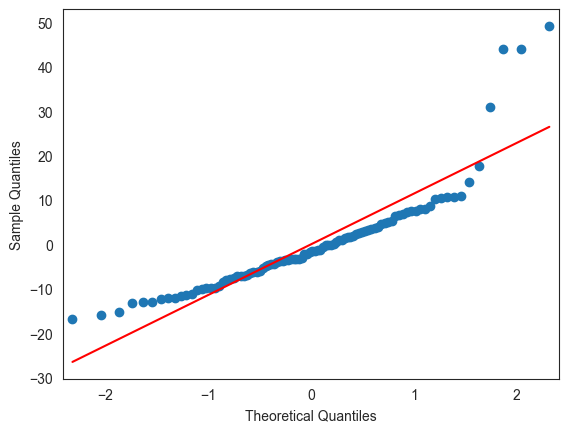

In [305]:
import scipy.stats as stats
import matplotlib.pyplot as plt

sm.qqplot(model1.resid, line='s')
plt.show()

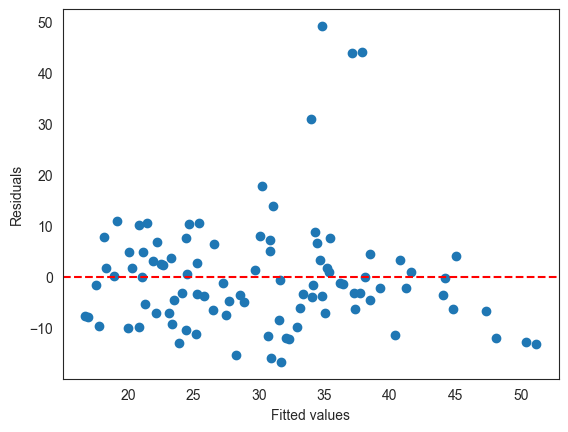

In [306]:
plt.scatter(model1.fittedvalues, model1.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

In [307]:
top_setup['residuals'] = model1.resid
outliers = top_setup.sort_values(by='residuals', ascending=False).head(5)
print(outliers)

    strategy_name model_name  version dataset_name  total_score  all_possible  \
0     contrastive     Qwen7B        3        raven         84.0           100   
1          direct     Qwen7B        3        raven         82.0           100   
2          direct     Qwen7B        1        raven         81.0           100   
3     contrastive     Qwen7B        1        raven         65.0           100   
7  classification    LLaVA7B        1           bp         48.0           100   

   correctness  residuals  
0         84.0  49.219223  
1         82.0  44.130208  
2         81.0  43.924716  
3         65.0  31.013731  
7         48.0  17.743371  


In [308]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

model_formula = 'correctness ~ C(model_name) + C(strategy_name) + C(version) + C(dataset_name)'

model2 = ols(model_formula, data=top_setup[(top_setup["dataset_name"]!="raven") & (top_setup["version"]!=2)]).fit()

anova_table = sm.stats.anova_lm(model2, typ=2)
print(anova_table)

                       sum_sq    df          F        PR(>F)
C(model_name)      489.634355   2.0   7.662170  1.050703e-03
C(strategy_name)   123.364411   3.0   1.287000  2.866071e-01
C(version)           6.204804   1.0   0.194195  6.609564e-01
C(dataset_name)   1964.016931   2.0  30.734426  4.839669e-10
Residual          2012.939250  63.0        NaN           NaN


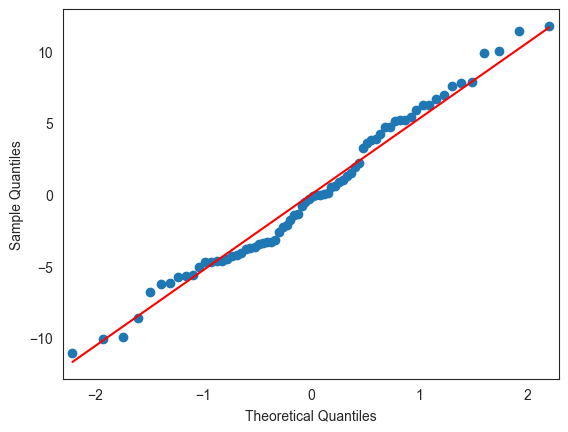

In [309]:
import matplotlib.pyplot as plt
import scipy.stats as stats

sm.qqplot(model2.resid, line='s')
plt.show()

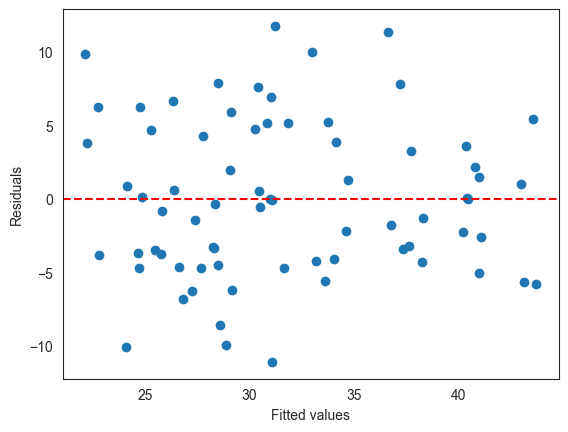

In [310]:
plt.scatter(model2.fittedvalues, model2.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

## Matrices

### Plotting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def _problem_id(i, j, zero_indexed):
    return i * 10 + j if zero_indexed else i * 10 + j + 1

def _get_extremes(values, top_k=3):
    zero_cells = np.argwhere(values == 0)
    flat_indices = np.argsort(values, axis=None)[-top_k:]
    top_cells = [np.unravel_index(i, values.shape) for i in flat_indices]
    return zero_cells, top_cells

def _make_colormap():
    return LinearSegmentedColormap.from_list("white_to_green", ["#ffffff", "#006400"])

def _plot_heatmap(ax, values, title, max_score, zero_indexed, highlight_extremes, cmap):
    im = ax.imshow(values, cmap=cmap, vmin=0, vmax=max_score)
    zero_cells, top_cells = ([], [])
    if highlight_extremes:
        zero_cells, top_cells = _get_extremes(values)

    for i in range(10):
        for j in range(10):
            pid = _problem_id(i, j, zero_indexed)
            ax.text(j, i, str(pid), ha="center", va="center", fontsize=12)
            if highlight_extremes:
                if values[i, j] == 0:
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor="red", linewidth=2))
                if (i, j) in top_cells:
                    ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=False, edgecolor="blue", linewidth=2))

    ax.set_title(title)
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_xticklabels(range(10) if zero_indexed else range(1, 11))
    return im, zero_cells, top_cells

def generate_10x10_result_matrix(
    df,
    dataset_name=None,
    model_name=None,
    strategy_name=None,
    type_name=None,
    versions=None,
    zero_indexed_problem_ids=False
):
    df = df.copy()
    filters = {
        "dataset_name": dataset_name,
        "model_name": model_name,
        "strategy_name": strategy_name,
        "type_name": type_name,
        "version": versions,
    }

    for col, val in filters.items():
        if val is None:
            continue
        if isinstance(val, (list, tuple, set, range)):
            df = df[df[col].isin(val)]
        else:
            df = df[df[col] == val]

    scores = df.groupby("problem_id")["is_correct"].sum()
    offset = 0 if zero_indexed_problem_ids else 1

    matrix = pd.DataFrame(0, index=range(10), columns=range(10))
    for pid, score in scores.items():
        row, col = divmod(pid - offset, 10)
        if 0 <= row < 10 and 0 <= col < 10:
            matrix.iloc[row, col] = score

    return matrix

def plot_matrices(
    matrices,
    titles,
    zero_indexed_flags=None,
    max_score=None,
    main_title="10x10 Matrices (2x2)",
    highlight_extremes=False,
    font_size=14
):
    """
    Plot up to 4 10x10 matrices in a 2x2 grid with a colorbar that does not overlap.
    Each matrix can independently be zero-indexed or one-indexed.
    """
    n = len(matrices)
    assert 1 <= n <= 4, "2x2 grid supports 1 to 4 matrices"
    assert len(titles) == n
    if zero_indexed_flags is None:
        zero_indexed_flags = [False] * n
    assert len(zero_indexed_flags) == n

    plt.rcParams.update({'font.size': font_size})
    max_score = max(matrix.values.max() for matrix in matrices) if max_score is None else max_score
    cmap = _make_colormap()

    fig = plt.figure(figsize=(12, 12))
    gs = fig.add_gridspec(2, 2, wspace=0.3, hspace=0.3)
    axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]

    im_list = []

    for idx, (matrix, title, zero_indexed) in enumerate(zip(matrices, titles, zero_indexed_flags)):
        ax = axes[idx]
        values = matrix.values

        im, zero_cells, top_cells = _plot_heatmap(
            ax,
            values,
            title,
            max_score,
            zero_indexed,
            highlight_extremes,
            cmap
        )
        im_list.append(im)

        if highlight_extremes:
            zero_ids = sorted(_problem_id(i,j,zero_indexed) for i,j in zero_cells)
            print(f"\n{title}\n{'-'*len(title)}")
            print(f"Zero-value problems : {len(zero_ids)} → {zero_ids if zero_ids else 'None'}")
            print("Top problems (problem_id : is_correct)")
            for i,j in top_cells:
                pid = _problem_id(i,j,zero_indexed)
                print(f"  → {pid} : {values[i,j]}")

        ax.set_xticks(range(10))
        ax.set_yticks(range(10))
        y_labels = [f"{i*10}-{i*10+9}" if zero_indexed else f"{i*10+1}-{i*10+10}" for i in range(10)]
        ax.set_yticklabels(y_labels, fontsize=12)

    axes[0].set_ylabel("Problem ID range", fontsize=14)
    axes[1].set_xlabel("Problem (within block)", fontsize=14)

    for ax in axes[n:]:
        ax.axis("off")

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im_list[0], cax=cbar_ax)
    cbar.set_label("Sum of is_correct", fontsize=14)

    fig.suptitle(main_title, fontsize=20)
    plt.show()


### Matrices - datasets


CVR
---
Zero-value problems : 0 → None
Top problems (problem_id : is_correct)
  → 99 : 12
  → 82 : 13
  → 64 : 14

RAVEN
-----
Zero-value problems : 1 → [np.int64(38)]
Top problems (problem_id : is_correct)
  → 23 : 10
  → 28 : 10
  → 21 : 11

MaRS-VQA
--------
Zero-value problems : 0 → None
Top problems (problem_id : is_correct)
  → 88 : 12
  → 71 : 12
  → 59 : 15

BP
--
Zero-value problems : 0 → None
Top problems (problem_id : is_correct)
  → 77 : 15.0
  → 83 : 15.5
  → 47 : 15.5


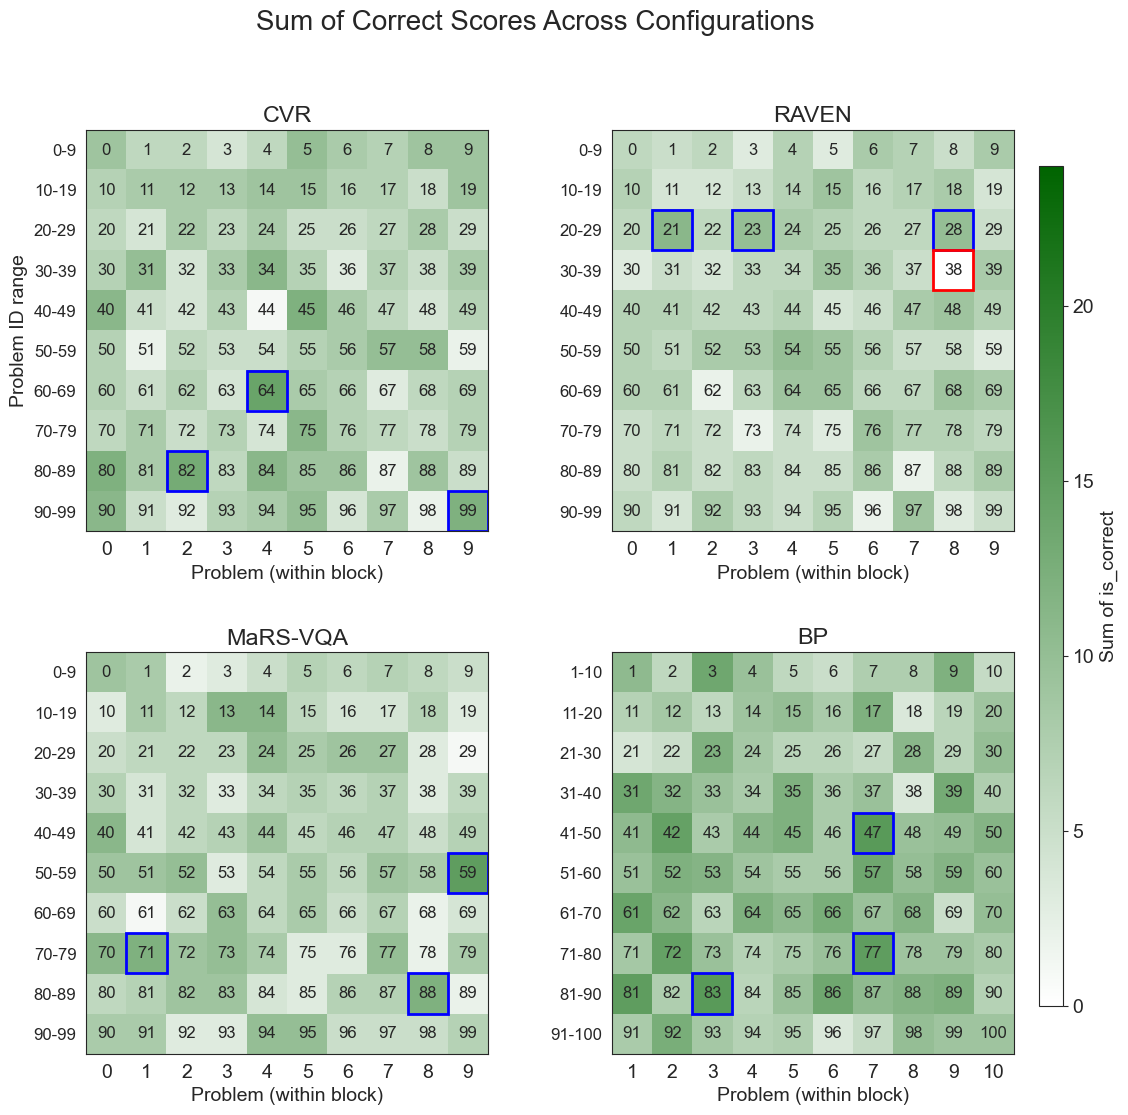

In [495]:
m1 = generate_10x10_result_matrix(df_singles, dataset_name="cvr", versions=[1,3], zero_indexed_problem_ids=True)
m2 = generate_10x10_result_matrix(df_singles, dataset_name="raven", versions=[1,3], zero_indexed_problem_ids=True)
m3 = generate_10x10_result_matrix(df_singles, dataset_name="marsvqa", versions=[1,3], zero_indexed_problem_ids=True)
m4 = generate_10x10_result_matrix(df_singles, dataset_name="bp", versions=[1,3], zero_indexed_problem_ids=False)
plot_matrices([m1,m2,m3,m4],["CVR", "RAVEN", "MaRS-VQA", "BP"],max_score=24, main_title="Sum of Correct Scores Across Configurations",highlight_extremes=True, zero_indexed_flags=[True, True, True, False],)

## Boxplots

### Plotting

In [316]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correctness_boxplots(
    df,
    dataset_names=None,
    model_names=None,
    strategy_names=None,
    type_name=None,
    versions=None,
    value_col="correctness",
    figsize=(10,6),
    title="Correctness Boxplots",
    x_column="strategy_name",
    hue=None,
    palette=["#48a6fe", "#fc9f26", "#a7ed51", "#976ef0"],
):
    
    df_filtered = df.copy()
    if hue is None:
        palette = [palette[0]]

    if x_column == "model_name":
        df_filtered["model_name"] = df_filtered["model_name"].apply(shorten_model_name)

    filters = {
        "dataset_name": dataset_names,
        "model_name": model_names,
        "strategy_name": strategy_names,
        "type_name": type_name,
        "version": versions
    }


    for col, val in filters.items():
        if val is None:
            continue
        if isinstance(val, (list, tuple, set, range)):
            df_filtered = df_filtered[df_filtered[col].isin(val)]
        else:
            df_filtered = df_filtered[df_filtered[col] == val]

    if df_filtered.empty:
        raise ValueError("No data left after filtering. Check your filter selections.")
    
    plt.figure(figsize=figsize)
    sns.boxplot(
        data=df_filtered,
        x=x_column,
        y=value_col,
        hue=hue,
        palette=palette
    )
    sns.set_style("white")

    plt.title(title, fontsize=18)
    plt.ylabel("Correctness (%)", fontsize=16)
    plt.ylim(0, 100)
    plt.xlabel(x_column.replace("_", " ").title(), fontsize=16)
    
    if hue is not None:
        plt.legend(title=hue.replace("_", " ").title(), fontsize=12)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()


### Prompt versions

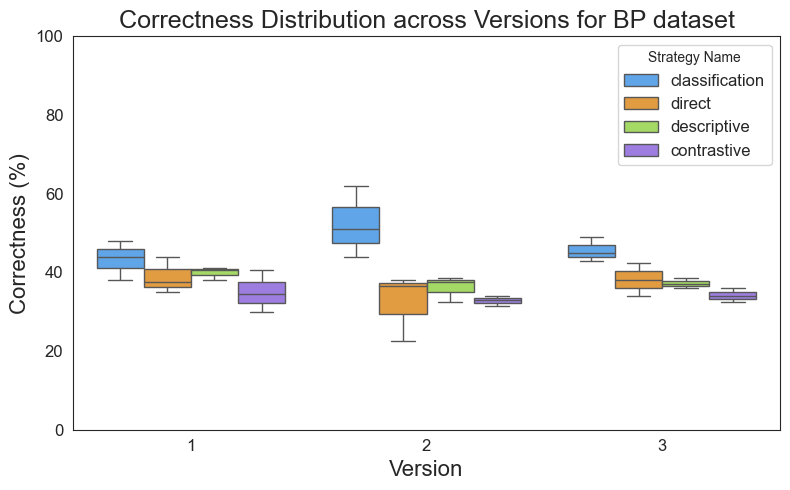

In [317]:
plot_correctness_boxplots(
    top_setup[top_setup["dataset_name"]=="bp"],
    versions=[1,2,3],
    value_col="correctness",
    figsize=(8,5),
    title="Correctness Distribution across Versions for BP dataset",
    x_column="version",
    hue="strategy_name"
)

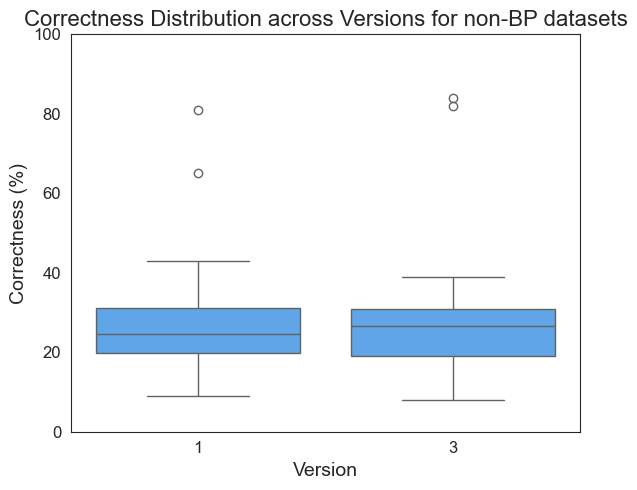

In [225]:
plot_correctness_boxplots(
    top_setup[top_setup["dataset_name"]!="bp"],
    versions=[1,3],
    value_col="correctness",
    figsize=(6,5),
    title="Correctness Distribution across Versions for non-BP datasets",
    x_column="version",
)

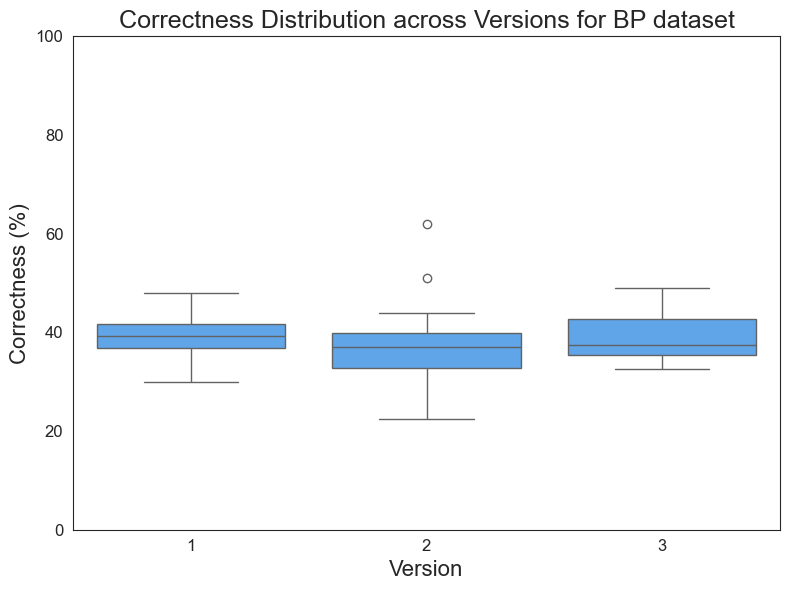

In [318]:
plot_correctness_boxplots(
    top_setup[top_setup["dataset_name"]=="bp"],
    versions=[1,2,3],
    value_col="correctness",
    figsize=(8,6),
    title="Correctness Distribution across Versions for BP dataset",
    x_column="version",
)

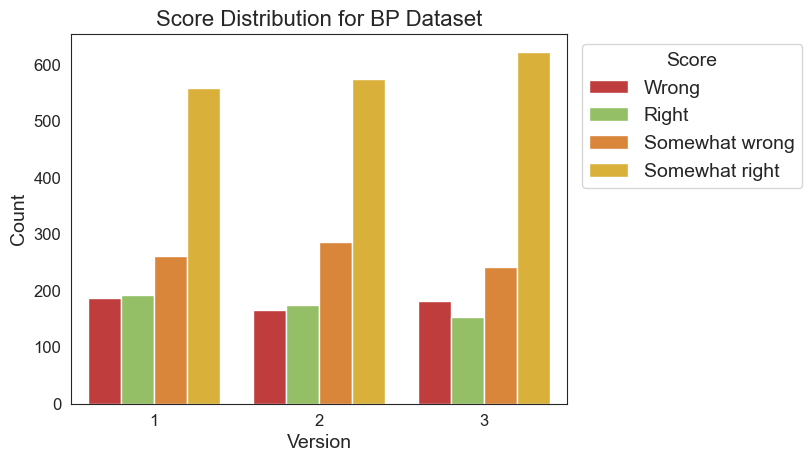

In [439]:
hist_bp = df_singles[df_singles["dataset_name"] == "bp"]

hist_bp = (
    hist_bp
    .groupby(["version", "score"])
    .size()
    .reset_index(name="cnt")
    .sort_values(by=["cnt"])
)

hist_bp = hist_bp[hist_bp["score"]!="Unclear"]

sns.barplot(
    data=hist_bp,
    x="version",
    y="cnt",    
    hue="score",
    palette={
        "Right": "#95cd59",
        "Somewhat right": "#f3be20",
        "Somewhat wrong": "#f38320",
        "Wrong": "#d62728",
        "Unclear": "#7f7f7f",
        "No answer provided": "#69aee3"
    }
)
plt.title("Score Distribution for BP Dataset", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Version", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.legend(title="Score", fontsize=12)
ax = plt.gca()
ax.legend(
    title="Score",
    bbox_to_anchor=(1.01, 1),
    loc="upper left"
)

plt.show()

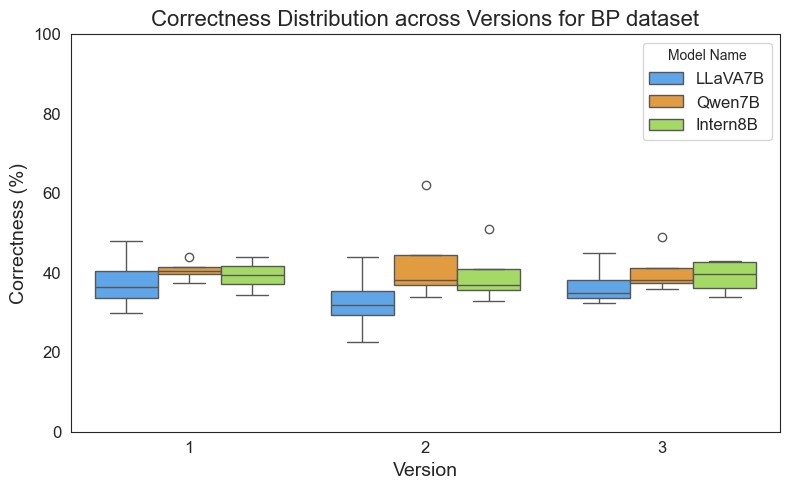

In [227]:
plot_correctness_boxplots(
    top_setup[top_setup["dataset_name"]=="bp"],
    versions=[1,2,3],
    value_col="correctness",
    figsize=(8,5),
    title="Correctness Distribution across Versions for BP dataset",
    x_column="version",
    hue="model_name"
)

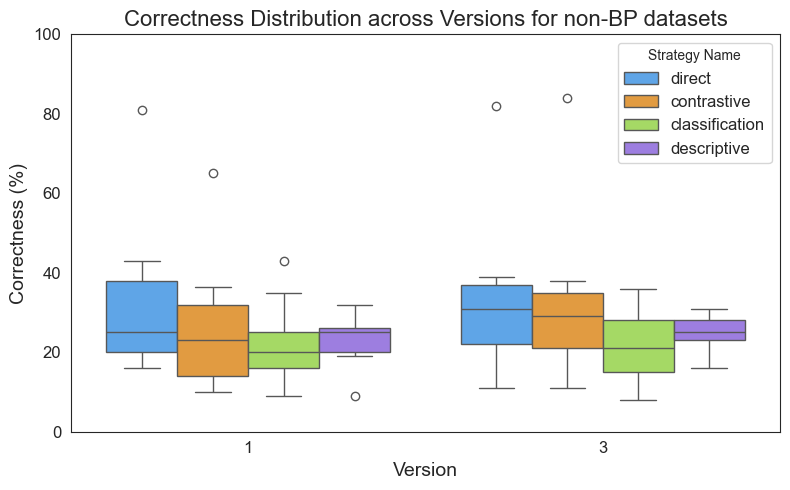

In [228]:
plot_correctness_boxplots(
    top_setup[top_setup["dataset_name"]!="bp"],
    versions=[1,3],
    value_col="correctness",
    figsize=(8,5),
    title="Correctness Distribution across Versions for non-BP datasets",
    x_column="version",
    hue="strategy_name"
)

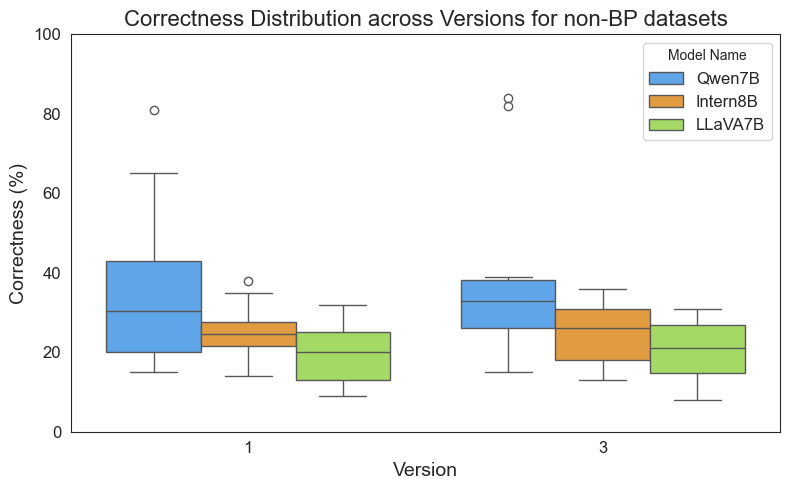

In [229]:
plot_correctness_boxplots(
    top_setup[top_setup["dataset_name"]!="bp"],
    versions=[1,3],
    value_col="correctness",
    figsize=(8,5),
    title="Correctness Distribution across Versions for non-BP datasets",
    x_column="version",
    hue="model_name"
)

### Models

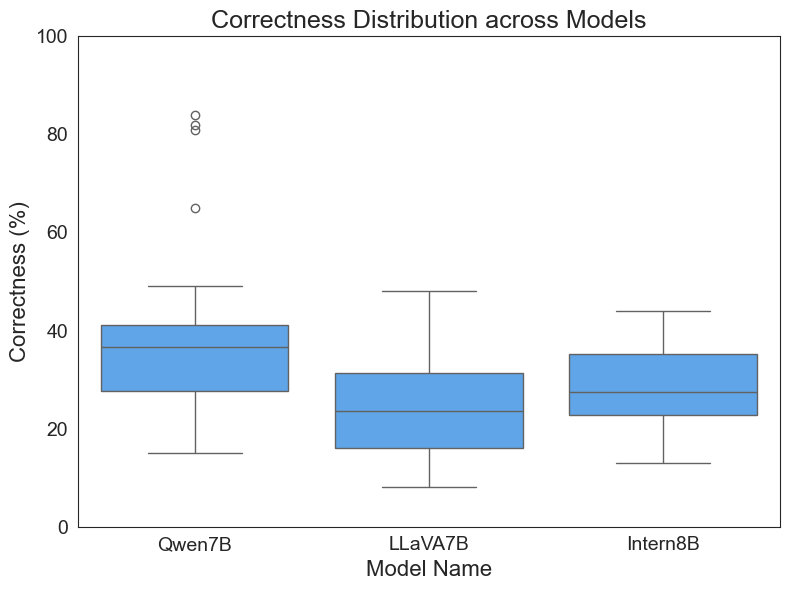

In [245]:
plot_correctness_boxplots(
    top_setup,
    versions=[1,3],
    value_col="correctness",
    figsize=(8,6),
    title="Correctness Distribution across Models",
    x_column="model_name",
    # hue="dataset_name"
)

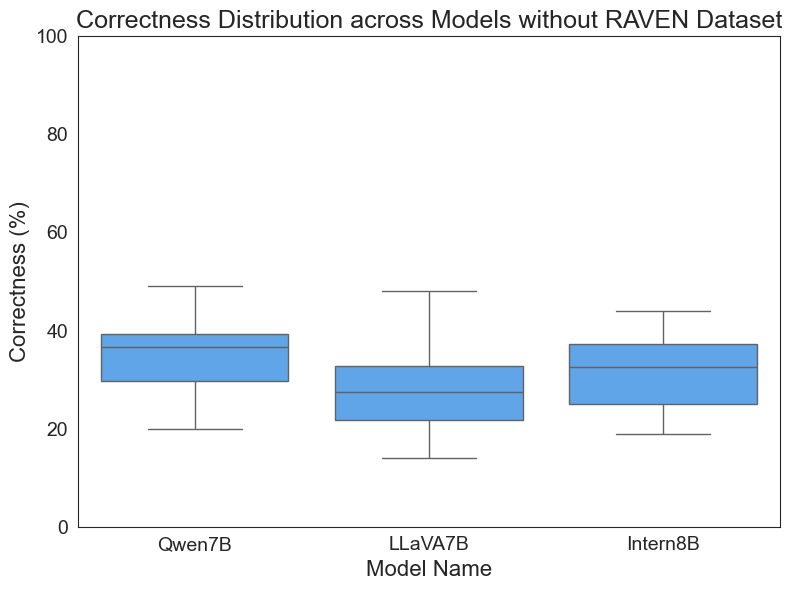

In [246]:
plot_correctness_boxplots(
    top_setup[top_setup["dataset_name"]!="raven"],
    versions=[1,3],
    value_col="correctness",
    figsize=(8,6),
    title="Correctness Distribution across Models without RAVEN Dataset",
    x_column="model_name",
    # hue="dataset_name"
)

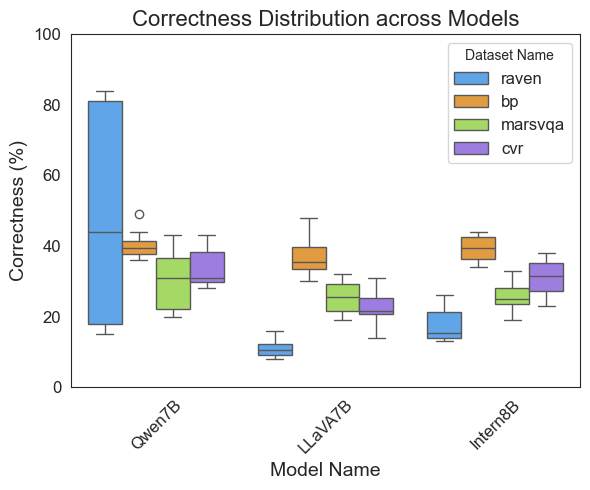

In [214]:
plot_correctness_boxplots(
    top_setup,
    versions=[1,3],
    value_col="correctness",
    figsize=(6,5),
    title="Correctness Distribution across Models",
    x_column="model_name",
    hue="dataset_name"
)

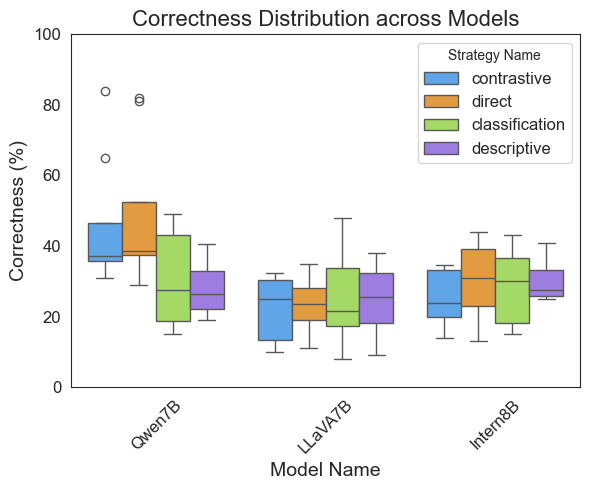

In [215]:
plot_correctness_boxplots(
    top_setup,
    versions=[1,3],
    value_col="correctness",
    figsize=(6,5),
    title="Correctness Distribution across Models",
    x_column="model_name",
    hue="strategy_name"
)

### Strategies

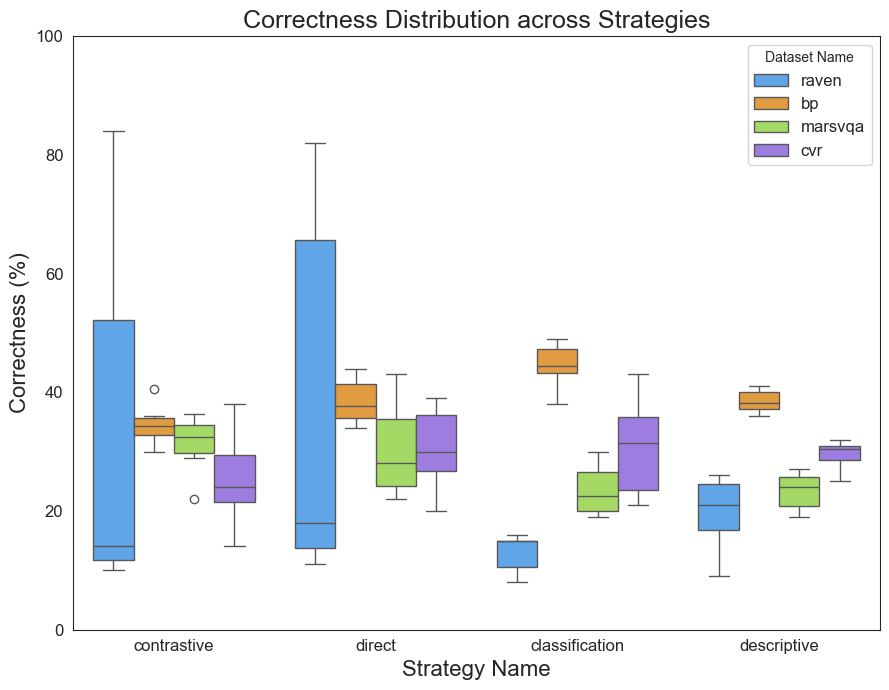

In [363]:
plot_correctness_boxplots(
    top_setup,
    versions=[1,3],
    value_col="correctness",
    figsize=(9,7),
    title="Correctness Distribution across Strategies",
    x_column="strategy_name",
    hue="dataset_name"
)

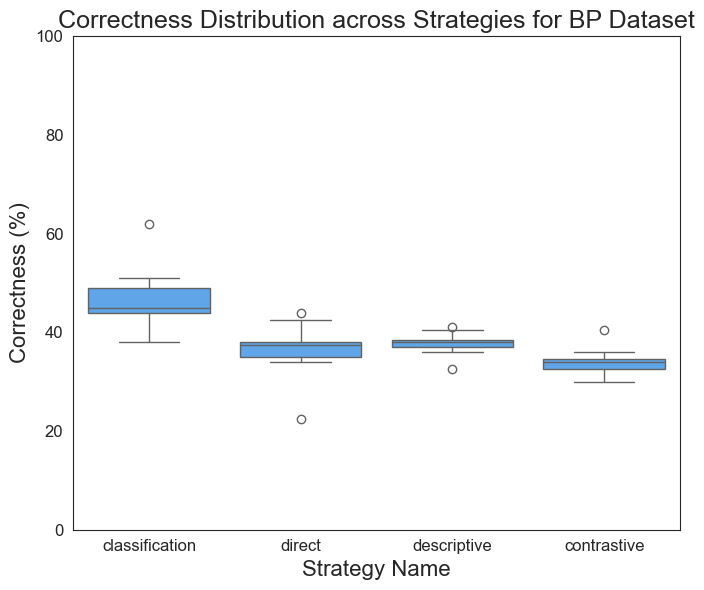

In [355]:
plot_correctness_boxplots(
    top_setup[top_setup["dataset_name"]=="bp"],
    versions=[1,2,3],
    value_col="correctness",
    figsize=(7,6),
    title="Correctness Distribution across Strategies for BP Dataset",
    x_column="strategy_name",
)

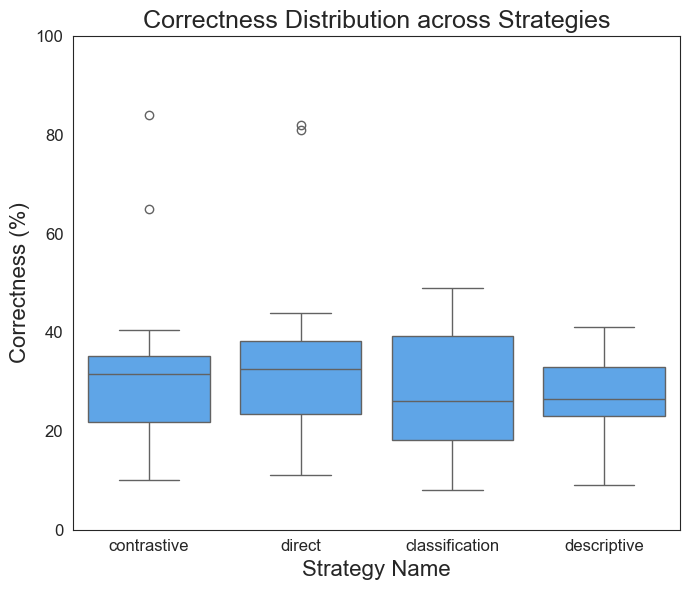

In [357]:
plot_correctness_boxplots(
    top_setup,
    versions=[1,3],
    value_col="correctness",
    figsize=(7,6),
    title="Correctness Distribution across Strategies",
    x_column="strategy_name",
)

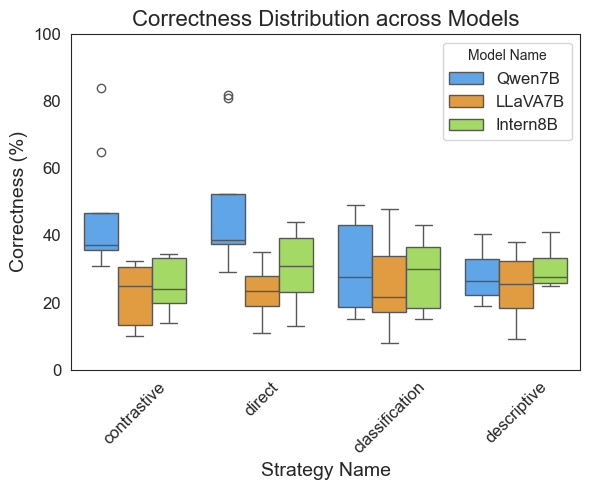

In [219]:
plot_correctness_boxplots(
    top_setup,
    versions=[1,3],
    value_col="correctness",
    figsize=(6,5),
    title="Correctness Distribution across Models",
    x_column="strategy_name",
    hue="model_name"
)

## BP performance across strategies

In [374]:
top_setup_nhs = df_singles_no_half_scores.copy()

top_setup_nhs = top_setup_nhs[top_setup_nhs["version"].isin([1,2,3]) & (top_setup_nhs["dataset_name"]=="bp")]

group_cols=["strategy_name", "model_name"]

grouped = top_setup_nhs.groupby(group_cols)["is_correct"]
score = grouped.sum()
total = grouped.count()
correctness = score / total * 100

top_setup_nhs = pd.DataFrame({
    "total_score": score,
    "all_possible": total,
    "correctness": correctness
}).reset_index()

top_setup_nhs_pivot = top_setup_nhs.pivot(index="model_name", columns="strategy_name", values="correctness").reset_index()

top_setup_nhs_pivot.head(12)

strategy_name,model_name,classification,contrastive,descriptive,direct
0,Intern8B,44.000000,3.333333,5.666667,5.666667
1,LLaVA7B,45.666667,1.666667,2.666667,1.333333
2,Qwen7B,51.666667,3.333333,5.000000,3.333333


In [378]:
top_setup_nhs_avg = top_setup_nhs.copy()
top_setup_nhs_avg = top_setup_nhs_avg.groupby("strategy_name")["correctness"].mean().reset_index()
top_setup_nhs_avg.head()

,strategy_name,correctness
0,classification,47.111111
1,contrastive,2.777778
2,descriptive,4.444444
3,direct,3.444444
